In [1]:
!pip install opencv-python

In [2]:
!pip install tensorflow

In [4]:
!pip install scikit-learn


  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
   ---------------------------------------- 0.0/8.9 MB ? eta -:--:--
   - -------------------------------------- 0.3/8.9 MB ? eta -:--:--
   -- ------------------------------------- 0.5/8.9 MB 2.4 MB/s eta 0:00:04
   ---- ----------------------------------- 1.0/8.9 MB 2.1 MB/s eta 0:00:04
   -------- ------------------------------- 1.8/8.9 MB 2.6 MB/s eta 0:00:03
   ----------- ---------------------------- 2.6/8.9 MB 2.9 MB/s eta 0:00:03
   --------------- ------------------------ 3.4/8.9 MB 2.9 MB/s eta 0:00:02
   ------------------ --------------------- 4.2/8.9 MB 3.0 MB/s eta 0:00:02
   --------------------- ------------------ 4.7/8.9 MB 3.1 MB/s eta 0:00:02
   ------------------------- -------------- 5.8/8.9 MB 3.2 MB/s eta 0:00:01
   ----------------------------- ---------- 6.6/8.9 MB 3.3 MB/s eta 0:00:01
   --------------------------------- ------ 7.3/8.9 MB 3.4 MB/s eta 0:00:01
   ------------------------------

In [74]:
# Import necessary packages
import cv2
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from sklearn.preprocessing import Normalizer, LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics.pairwise import cosine_similarity
from mtcnn import MTCNN
import pickle
from PIL import Image

## Step 1: Load FaceNet Model and Initialize Face Detector

In [78]:
# Option 1: Install and use keras-facenet (recommended)
# First, run: !pip install keras-facenet

try:
    from keras_facenet import FaceNet
    print("Using keras-facenet package...")
    facenet_model = FaceNet()
    print("FaceNet model loaded successfully!")
except ImportError:
    print("keras-facenet not found. Installing...")
    import subprocess
    subprocess.check_call(['pip', 'install', 'keras-facenet'])
    from keras_facenet import FaceNet
    facenet_model = FaceNet()
    print("FaceNet model loaded successfully!")

# Initialize MTCNN face detector
print("Initializing MTCNN face detector...")
detector = MTCNN()
print("Face detector initialized!")

Using keras-facenet package...
FaceNet model loaded successfully!
Initializing MTCNN face detector...
Face detector initialized!


## Step 2: Define Helper Functions for Face Detection and Embedding

In [81]:
def extract_face(image_path, required_size=(160, 160)):
    """
    Extract face from image using MTCNN detector
    Returns: Face pixels array or None if no face detected
    """
    # Load image
    img = cv2.imread(image_path)
    if img is None:
        return None
    
    # Convert BGR to RGB
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Detect faces
    results = detector.detect_faces(img_rgb)
    
    if len(results) == 0:
        return None
    
    # Extract the bounding box from the first face
    x1, y1, width, height = results[0]['box']
    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height
    
    # Extract face
    face = img_rgb[y1:y2, x1:x2]
    
    # Resize to required size
    face_resized = cv2.resize(face, required_size)
    
    return face_resized


def get_embedding(face_pixels):
    """
    Get face embedding from FaceNet model
    Works with keras-facenet package
    """
    # Ensure face is the right shape
    if len(face_pixels.shape) == 3:
        face_pixels = np.expand_dims(face_pixels, axis=0)
    
    # Get embedding using keras-facenet
    embedding = facenet_model.embeddings(face_pixels)
    
    return embedding[0]


def load_faces_from_folder(folder_path):
    """
    Load all faces from a folder and extract embeddings
    Returns: List of embeddings
    """
    embeddings = []
    
    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
            img_path = os.path.join(folder_path, filename)
            
            # Extract face
            face = extract_face(img_path)
            
            if face is not None:
                # Get embedding
                embedding = get_embedding(face)
                embeddings.append(embedding)
                print(f"✓ Processed: {filename}")
            else:
                print(f"✗ No face detected in: {filename}")
    
    return embeddings

print("Helper functions defined successfully!")

Helper functions defined successfully!


## Step 3: Load Dataset and Extract Embeddings

In [82]:
# Load dataset
dataset_dir = "dataset"
X_train = []  # Embeddings
y_train = []  # Labels

print("Loading dataset and extracting embeddings...\n")

# Iterate through each person's folder
for person_name in os.listdir(dataset_dir):
    person_folder = os.path.join(dataset_dir, person_name)
    
    if os.path.isdir(person_folder):
        print(f"\nProcessing '{person_name}' folder:")
        print("-" * 50)
        
        # Load faces and get embeddings
        embeddings = load_faces_from_folder(person_folder)
        
        # Add to training data
        for embedding in embeddings:
            X_train.append(embedding)
            y_train.append(person_name)
        
        print(f"Total embeddings for {person_name}: {len(embeddings)}")

# Convert to numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)

print("\n" + "="*50)
print(f"Total training samples: {len(X_train)}")
print(f"Embedding shape: {X_train[0].shape}")
print(f"Classes: {np.unique(y_train)}")
print("="*50)

Loading dataset and extracting embeddings...


Processing 'kechrith' folder:
--------------------------------------------------
1/1 [==============================] - 2s 2s/step
✓ Processed: photo_10_2025-10-18_23-00-08.jpg
✗ No face detected in: photo_11_2025-10-18_23-00-08.jpg
1/1 [==============================] - 0s 239ms/step
✓ Processed: photo_12_2025-10-18_23-00-08.jpg
1/1 [==============================] - 0s 221ms/step
✓ Processed: photo_13_2025-10-18_23-00-08.jpg
1/1 [==============================] - 0s 208ms/step
✓ Processed: photo_14_2025-10-18_23-00-08.jpg
1/1 [==============================] - 0s 211ms/step
✓ Processed: photo_15_2025-10-18_23-00-08.jpg
1/1 [==============================] - 0s 223ms/step
✓ Processed: photo_16_2025-10-18_23-00-08.jpg
1/1 [==============================] - 0s 245ms/step
✓ Processed: photo_1_2025-10-18_23-00-08.jpg
1/1 [==============================] - 0s 239ms/step
✓ Processed: photo_1_2025-10-18_23-03-31.jpg
1/1 [========================

## Step 4: Normalize Embeddings and Train SVM Classifier

In [83]:
# Normalize embeddings
print("Normalizing embeddings...")
in_encoder = Normalizer(norm='l2')
X_train_norm = in_encoder.transform(X_train)

# Encode labels
print("Encoding labels...")
out_encoder = LabelEncoder()
y_train_encoded = out_encoder.fit_transform(y_train)

# Train SVM classifier
print("\nTraining SVM classifier...")
model = SVC(kernel='linear', probability=True)
model.fit(X_train_norm, y_train_encoded)

print("\nModel trained successfully!")
print(f"Classes: {out_encoder.classes_}")

Normalizing embeddings...
Encoding labels...

Training SVM classifier...

Model trained successfully!
Classes: ['kechrith' 'sopanha']


## Step 5: Save the Trained Model and Encoders

In [84]:
# Save the trained model and encoders
print("Saving model and encoders...")

# Create models directory if it doesn't exist
os.makedirs('models', exist_ok=True)

# Save SVM model
with open('models/svm_model.pkl', 'wb') as f:
    pickle.dump(model, f)

# Save label encoder
with open('models/label_encoder.pkl', 'wb') as f:
    pickle.dump(out_encoder, f)

print("Model saved to 'models/svm_model.pkl'")
print("Label encoder saved to 'models/label_encoder.pkl'")
print("\nTraining complete! Ready for real-time recognition.")

Saving model and encoders...
Model saved to 'models/svm_model.pkl'
Label encoder saved to 'models/label_encoder.pkl'

Training complete! Ready for real-time recognition.


## Step 6: Real-Time Facial Recognition
Run this cell to start real-time face recognition using your webcam.
- Press 'q' to quit
- Press 's' to take a screenshot

In [85]:
# Load the trained model and encoders
print("Loading trained model...")
with open('models/svm_model.pkl', 'rb') as f:
    model = pickle.load(f)

with open('models/label_encoder.pkl', 'rb') as f:
    out_encoder = pickle.load(f)

print("Model loaded successfully!")
print(f"Recognized classes: {out_encoder.classes_}")

# Initialize video capture
cap = cv2.VideoCapture(0)
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 1280)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)

if not cap.isOpened():
    print("Error: Cannot access camera")
else:
    print("\nStarting real-time facial recognition...")
    print("Press 'q' to quit")
    print("Press 's' to save screenshot\n")
    
    frame_count = 0
    
    while True:
        ret, frame = cap.read()
        if not ret:
            print("Failed to grab frame")
            break
        
        frame_count += 1
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        # Detect faces every frame
        results = detector.detect_faces(rgb_frame)
        
        for result in results:
            # Get bounding box
            x, y, width, height = result['box']
            x, y = abs(x), abs(y)
            x2, y2 = x + width, y + height
            
            # Extract and process face
            face = rgb_frame[y:y2, x:x2]
            
            if face.size > 0:
                try:
                    # Resize face
                    face_resized = cv2.resize(face, (160, 160))
                    
                    # Get embedding
                    embedding = get_embedding(face_resized)
                    
                    # Normalize
                    embedding_norm = in_encoder.transform([embedding])
                    
                    # Predict
                    yhat_class = model.predict(embedding_norm)
                    yhat_prob = model.predict_proba(embedding_norm)
                    
                    # Get prediction details
                    class_index = yhat_class[0]
                    class_probability = yhat_prob[0][class_index] * 100
                    predict_name = out_encoder.inverse_transform(yhat_class)[0]
                    
                    # Set color based on confidence
                    if class_probability > 70:
                        color = (0, 255, 0)  # Green for high confidence
                    elif class_probability > 50:
                        color = (0, 255, 255)  # Yellow for medium confidence
                    else:
                        color = (0, 165, 255)  # Orange for low confidence
                    
                    # Draw bounding box
                    cv2.rectangle(frame, (x, y), (x2, y2), color, 3)
                    
                    # Prepare text
                    text = f"{predict_name} ({class_probability:.1f}%)"
                    
                    # Draw text background
                    (text_width, text_height), baseline = cv2.getTextSize(
                        text, cv2.FONT_HERSHEY_SIMPLEX, 0.8, 2
                    )
                    cv2.rectangle(
                        frame, 
                        (x, y - text_height - 10), 
                        (x + text_width, y), 
                        color, 
                        -1
                    )
                    
                    # Draw text
                    cv2.putText(
                        frame, 
                        text, 
                        (x, y - 5), 
                        cv2.FONT_HERSHEY_SIMPLEX, 
                        0.8, 
                        (0, 0, 0), 
                        2
                    )
                    
                    # Draw confidence bar
                    bar_length = int((class_probability / 100) * width)
                    cv2.rectangle(
                        frame, 
                        (x, y2 + 5), 
                        (x + bar_length, y2 + 15), 
                        color, 
                        -1
                    )
                    
                except Exception as e:
                    print(f"Error processing face: {e}")
        
        # Add info overlay
        overlay_text = f"FPS: {frame_count % 30} | Faces: {len(results)} | Press 'q' to quit, 's' for screenshot"
        cv2.putText(
            frame, 
            overlay_text, 
            (10, 30), 
            cv2.FONT_HERSHEY_SIMPLEX, 
            0.6, 
            (255, 255, 255), 
            2
        )
        
        # Display frame
        cv2.imshow('Facial Recognition System', frame)
        
        # Handle key press
        key = cv2.waitKey(1) & 0xFF
        if key == ord('q'):
            print("Quitting...")
            break
        elif key == ord('s'):
            screenshot_name = f"screenshot_{frame_count}.jpg"
            cv2.imwrite(screenshot_name, frame)
            print(f"Screenshot saved: {screenshot_name}")
    
    # Cleanup
    cap.release()
    cv2.destroyAllWindows()
    print("\nFacial recognition stopped.")

Loading trained model...
Model loaded successfully!
Recognized classes: ['kechrith' 'sopanha']

Starting real-time facial recognition...
Press 'q' to quit
Press 's' to save screenshot

1/1 [==============================] - 0s 259ms/step
Screenshot saved: screenshot_19.jpg
1/1 [==============================] - 0s 273ms/step
Quitting...

Facial recognition stopped.


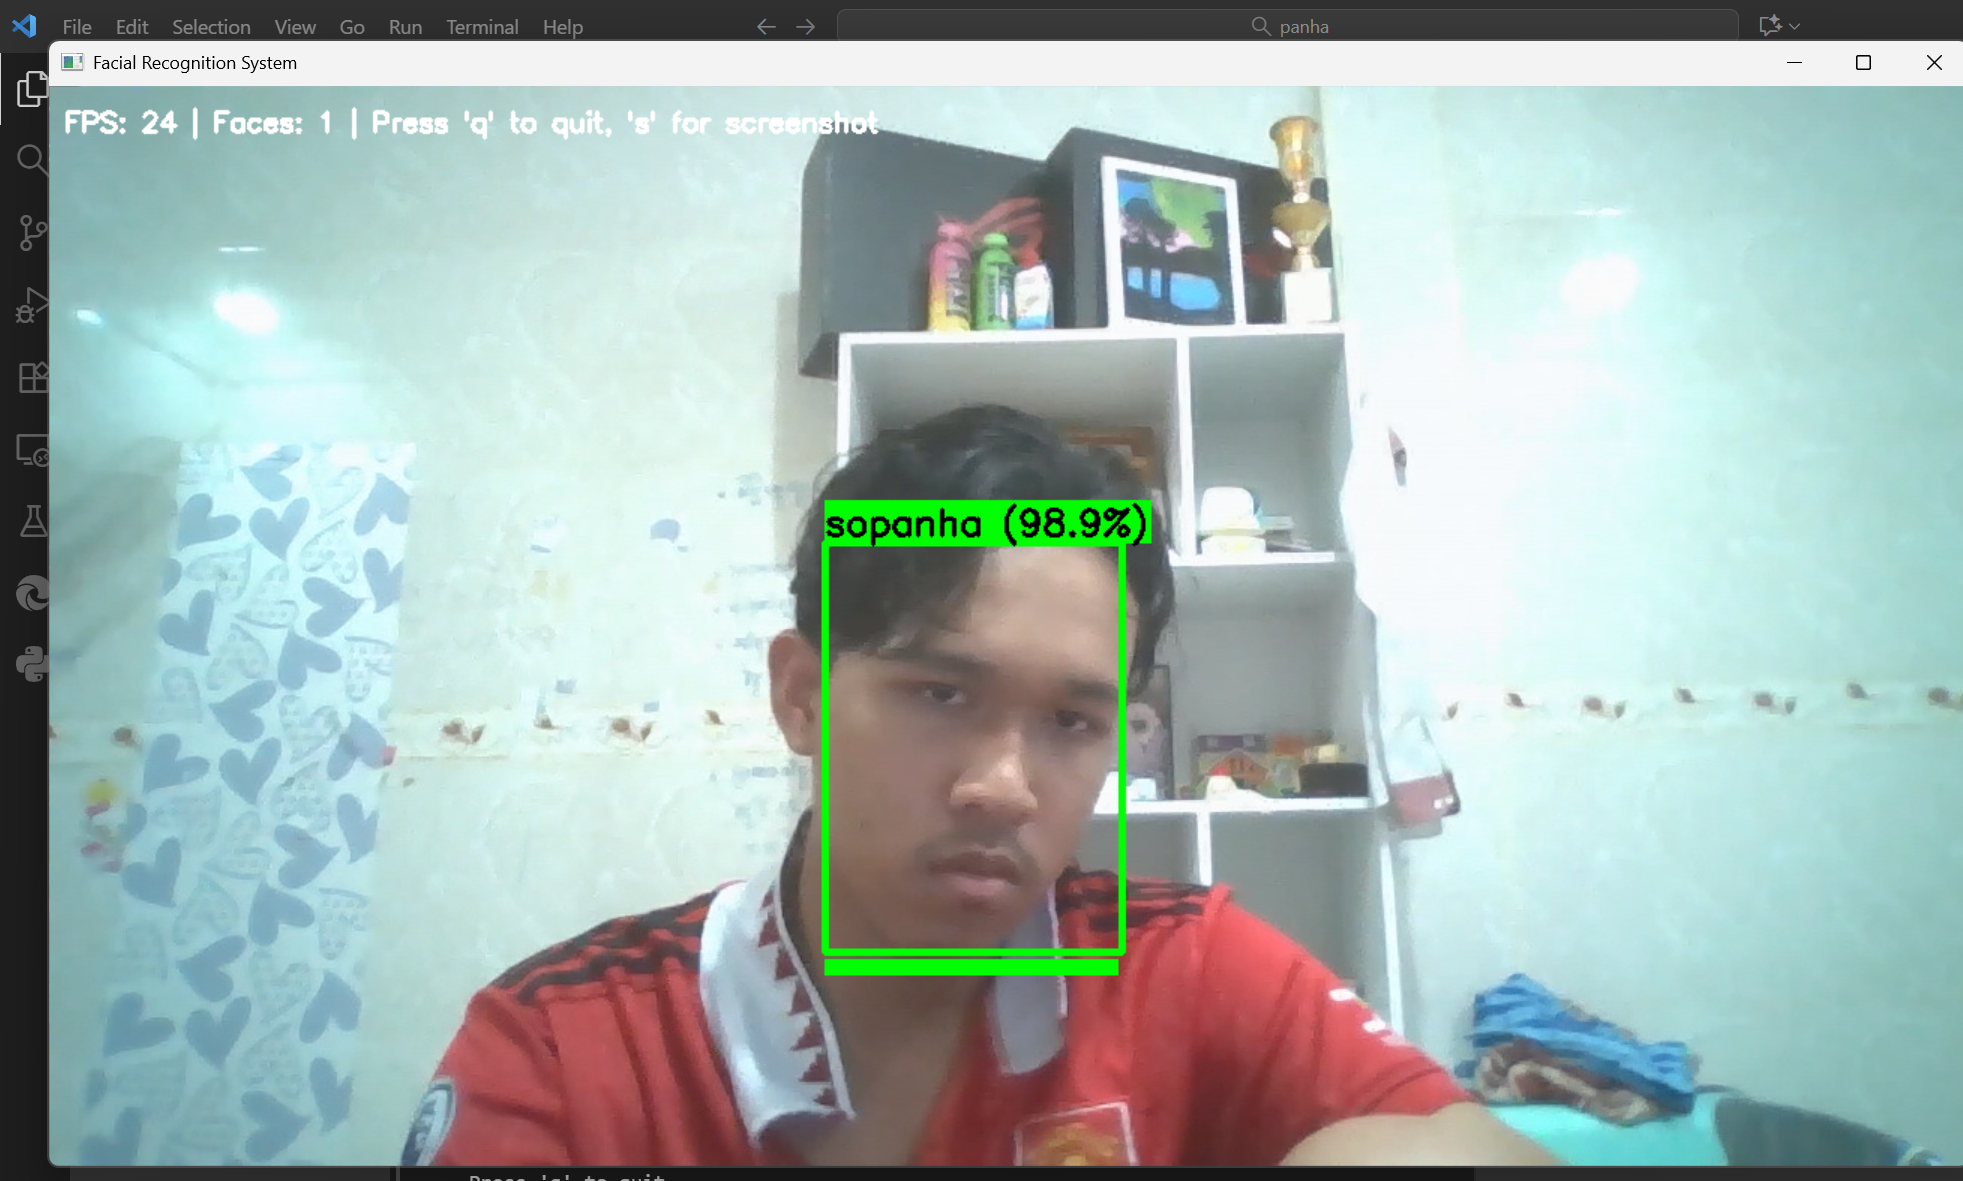

## Optional: Add New Person to Dataset
Run this cell if you want to add a new person to the recognition system.
After adding images, re-run the training cells (Step 3-5).

In [ ]:
# Capture images for a new person
import time

# Get person name
new_person_name = input("Enter the name of the new person: ").strip()

if new_person_name:
    # Create folder
    new_person_folder = os.path.join("dataset", new_person_name)
    os.makedirs(new_person_folder, exist_ok=True)
    
    # Initialize camera
    cam = cv2.VideoCapture(0)
    
    if not cam.isOpened():
        print("Error: Cannot access camera")
    else:
        print(f"\nCapturing 20 images for '{new_person_name}'")
        print("Position yourself in front of the camera")
        print("Images will be captured every 2 seconds")
        print("Press 'q' to quit early\n")
        
        count = 0
        last_capture_time = time.time()
        
        while count < 20:
            ret, frame = cam.read()
            if not ret:
                print("Failed to capture frame")
                break
            
            # Show countdown and preview
            current_time = time.time()
            time_since_last = current_time - last_capture_time
            remaining = max(0, 2 - time_since_last)
            
            # Display info on frame
            info_text = f"Capturing {count + 1}/20 | Next in: {remaining:.1f}s"
            cv2.putText(frame, info_text, (10, 30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
            cv2.putText(frame, f"Person: {new_person_name}", (10, 70), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
            
            cv2.imshow('Capturing Images', frame)
            
            # Capture image every 2 seconds
            if time_since_last >= 2:
                img_path = os.path.join(new_person_folder, f"{new_person_name}_{count + 1}.jpg")
                cv2.imwrite(img_path, frame)
                print(f"✓ Captured image {count + 1}/20")
                count += 1
                last_capture_time = current_time
            
            # Check for quit
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
        
        cam.release()
        cv2.destroyAllWindows()
        
        print(f"\nCapture complete! {count} images saved to '{new_person_folder}'")
        print("Now re-run cells from Step 3 to Step 5 to retrain the model.")
else:
    print("No name provided. Skipping...")

---
## How to Use This System

### First Time Setup:
1. Install requirements (cells 1-3)
2. Run cells to load model and initialize detector
3. Run Step 3-5 to train on your existing dataset (kechrith and sopanha)
4. Run Step 6 to start real-time recognition

### To Add a New Person:
1. Run the "Add New Person" cell
2. Enter the person's name
3. Capture 20 images (will happen automatically)
4. Re-run Steps 3-5 to retrain the model
5. Run Step 6 to test with the updated model

### Features:
- Real-time face detection and recognition
- Confidence score display (color-coded)
- FPS counter
- Screenshot capability (press 's')
- Support for multiple faces simultaneously
- High accuracy with FaceNet embeddings

### Color Coding:
- Green: High confidence (>70%)
- Yellow: Medium confidence (50-70%)
- Orange: Low confidence (<50%)

---

In [76]:
# Install required packages
!pip install mtcnn
!pip install pillow

# Real-Time Facial Recognition System
This notebook implements a complete facial recognition system using:
- FaceNet for face embeddings
- MTCNN for face detection
- SVM classifier for person identification
- OpenCV for real-time video processing

In [ ]:
# This cell has been replaced by the new data collection system
# See the "Optional: Add New Person to Dataset" section below for adding new people

In [ ]:
# This cell has been replaced by the new data collection system
# See the "Optional: Add New Person to Dataset" section below for adding new people